# Uploading files

In [ ]:
# upload evaluation.py, explanations.py, synset_words.txt, utils.py and images to be used
from google.colab import files
uploaded = files.upload()

Saving evaluation.py to evaluation.py
Saving explanations.py to explanations.py
Saving goldfish.jpg to goldfish.jpg
Saving synset_words.txt to synset_words.txt
Saving turtle.jpg to turtle.jpg
Saving utils.py to utils.py


# Evaluating causal metrics

In [ ]:
!pip install xplique
from xplique.attributions import (GradCAM, Rise)
import tensorflow.keras.applications as app
from xplique.metrics import Deletion, Insertion
import tensorflow as tf
import cv2
import xplique
from xplique.plots import plot_attributions

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d

from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE

cudnn.benchmark = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 29.4 MB/s 


## Preparing substrate functions

For our causal metrics we need functions that define how we delete/insert pixels. Specifically, we define mapping from old pixels to new pixels. We use zero substrate for deletion and blurred image substrate for insertion.

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

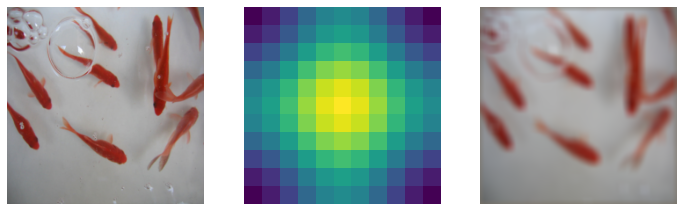

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = read_tensor('goldfish.jpg')
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

## Creating metrics and explainer instances

In [ ]:
def central_crop_and_resize(img, size=224):
  """
  Given a numpy array, extracts the largest possible square and resizes it to
  the requested size
  """
  h, w, _ = img.shape

  min_side = min(h, w)
  max_side_center = max(h, w) // 2.0
  
  min_cut = int(max_side_center-min_side//2)
  max_cut = int(max_side_center+min_side//2)
  
  img = img[:, min_cut:max_cut] if w > h else img[min_cut:max_cut]
  img = tf.image.resize(img, (size, size))


  return img 

def plot_histogram_d(deletion_scores, ticklabels):
    plt.style.use('seaborn-muted')

    x_pos = np.arange(len(deletion_scores))  # the label locations

    fig, axes = plt.subplots()

    # the actual bar plot
    axes.bar(
        x_pos,
        deletion_scores,
        align='center',
    )

    # add the metric score to the top of the bar
    ylen = plt.ylim()[1] - plt.ylim()[0]
    bbox = axes.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    yscale = ylen/bbox.height

    for i in x_pos:
        # put vertical lines for each method column
        plt.axvline(i, color="darkgrey", lw=0.5, dashes=(1, 5), zorder=-1)
        axes.text(
            x_pos[i],
            deletion_scores[i] + 0.2*yscale,
            str("%0.02f"%deletion_scores[i]),
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=12
        )

    # add some text for labels and custom y-axis tick labels
    axes.set_ylabel('Deletion score', fontsize=16)
    axes.set_title('Deletion on different attributions', fontsize=20)
    axes.set_xticks(x_pos)
    axes.set_xticklabels(ticklabels)
    axes.legend()

    # make the plot prettier
    fig.tight_layout()

    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

def plot_histogram_i(insertion_scores, ticklabels):
    plt.style.use('seaborn-muted')

    x_pos = np.arange(len(insertion_scores))  # the label locations

    fig, axes = plt.subplots()

    # the actual bar plot
    axes.bar(
        x_pos,
        insertion_scores,
        align='center',
    )

    # add the metric score to the top of the bar
    ylen = plt.ylim()[1] - plt.ylim()[0]
    bbox = axes.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    yscale = ylen/bbox.height

    for i in x_pos:
        # put vertical lines for each method column
        plt.axvline(i, color="darkgrey", lw=0.5, dashes=(1, 5), zorder=-1)
        axes.text(
            x_pos[i],
            insertion_scores[i] + 0.2*yscale,
            str("%0.02f"%insertion_scores[i]),
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=12
        )

    # add some text for labels and custom y-axis tick labels
    axes.set_ylabel('Insertion score', fontsize=16)
    axes.set_title('Insertion on different attributions', fontsize=20)
    axes.set_xticks(x_pos)
    axes.set_xticklabels(ticklabels)
    axes.legend()

    # make the plot prettier
    fig.tight_layout()

    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)

/usr/local/lib/python3.7/dist-packages/xplique/attributions/base.py:139: UserWarning: Output is after softmax, it is recommended to use the layer before.
  warnings.warn("Output is after softmax, it is recommended to "


Method: GradCAM


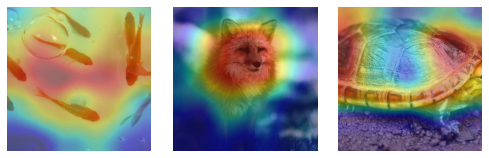



Method: Rise


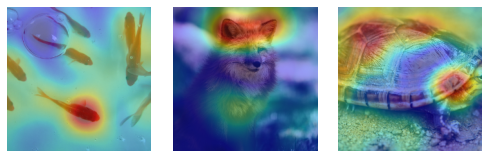

In [ ]:
# load, prepare and show a sample

#goldfish 1
#shark 2
#hen 8
#bulbul 16
#axolotl 29
#turtle 35
#tarantula 76
#toucan 96
#snail 113
#sea lion 150
#fox 277
#bee 309
#zebra 340
#armadillo 363
#gorilla 366
#microphone 650
#spatula 813
#toaster 859
#pretzel 932
#banana 954
"""img_list = [
    ('goldfish01.jpg', 1),
    ('shark01.jpg', 2),
    ('hen01.jpg', 8),
    ('bulbul01.jpg', 16),
    ('axolotl01.jpg', 29),
    ('turtle01.jpg', 35),
    ('tarantula01.jpg', 76),
    ('toucan01.jpg', 96),
    ('snail01.jpg', 113),
    ('sealion01.jpg', 150),
    ('fox01.jpg', 277),
    ('bee01.jpg', 309),
    ('zebra01.jpg', 340),
    ('armadillo01.jpg', 363),
    ('gorilla01.jpg', 366),
    ('microphone01.jpg', 650),
    ('spatula01.jpg', 813),
    ('toaster01.jpg', 859),
    ('pretzel01.jpg', 932),
    ('banana01.jpg', 954),
    ('goldfish02.jpg', 1),
    ('shark02.jpg', 2),
    ('hen02.jpg', 8),
    ('bulbul02.jpg', 16),
    ('axolotl02.jpg', 29),
    ('turtle02.jpg', 35),
    ('tarantula02.jpg', 76),
    ('toucan02.jpg', 96),
    ('snail02.jpg', 113),
    ('sealion02.jpg', 150),
    ('fox02.jpg', 277),
    ('bee02.jpg', 309),
    ('zebra02.jpg', 340),
    ('armadillo02.jpg', 363),
    ('gorilla02.jpg', 366),
    ('microphone02.jpg', 650),
    ('spatula02.jpg', 813),
    ('toaster02.jpg', 859),
    ('pretzel02.jpg', 932),
    ('banana02.jpg', 954),
    ('goldfish03.jpg', 1),
    ('shark03.jpg', 2),
    ('hen03.jpg', 8),
    ('bulbul03.jpg', 16),
    ('axolotl03.jpg', 29),
    ('turtle03.jpg', 35),
    ('tarantula03.jpg', 76),
    ('toucan03.jpg', 96),
    ('snail03.jpg', 113),
    ('sealion03.jpg', 150),
    ('fox03.jpg', 277),
    ('bee03.jpg', 309),
    ('zebra03.jpg', 340),
    ('armadillo03.jpg', 363),
    ('gorilla03.jpg', 366),
    ('microphone03.jpg', 650),
    ('spatula03.jpg', 813),
    ('toaster03.jpg', 859),
    ('pretzel03.jpg', 932),
    ('banana03.jpg', 954),
    ('goldfish04.jpg', 1),
    ('shark04.jpg', 2),
    ('hen04.jpg', 8),
    ('bulbul04.jpg', 16),
    ('axolotl04.jpg', 29),
    ('turtle04.jpg', 35),
    ('tarantula04.jpg', 76),
    ('toucan04.jpg', 96),
    ('snail04.jpg', 113),
    ('sealion04.jpg', 150),
    ('fox04.jpg', 277),
    ('bee04.jpg', 309),
    ('zebra04.jpg', 340),
    ('armadillo04.jpg', 363),
    ('gorilla04.jpg', 366),
    ('microphone04.jpg', 650),
    ('spatula04.jpg', 813),
    ('toaster04.jpg', 859),
    ('pretzel04.jpg', 932),
    ('banana04.jpg', 954),
    ('goldfish05.jpg', 1),
    ('shark05.jpg', 2),
    ('hen05.jpg', 8),
    ('bulbul05.jpg', 16),
    ('axolotl05.jpg', 29),
    ('turtle05.jpg', 35),
    ('tarantula05.jpg', 76),
    ('toucan05.jpg', 96),
    ('snail05.jpg', 113),
    ('sealion05.jpg', 150),
    ('fox05.jpg', 277),
    ('bee05.jpg', 309),
    ('zebra05.jpg', 340),
    ('armadillo05.jpg', 363),
    ('gorilla05.jpg', 366),
    ('microphone05.jpg', 650),
    ('spatula05.jpg', 813),
    ('toaster05.jpg', 859),
    ('pretzel05.jpg', 932),
    ('banana05.jpg', 954)
]"""

!wget -q 'https://unsplash.com/photos/XOxsVJmCyxk/download?force=true&w=640' -O 'fox.jpg'
img_list = [
    ('goldfish.jpg', 1),
    ('fox.jpg', 277),
    ('turtle.jpg', 35)    
]
imgs = []
labels = []

for img_name, label in img_list:
    img = tf.keras.preprocessing.image.load_img(img_name, target_size=(299, 299))
    label = tf.keras.utils.to_categorical(label, 1000)

    imgs.append(img)
    labels.append(label)

imgs = np.stack(imgs, axis=0)
imgs = np.array(imgs, dtype=np.float32) / 255.0

labels = np.stack(labels, axis=0)

# load the model and preprocess the inputs (adapt the input range)
model, preprocessing = app.MobileNetV2(), app.mobilenet_v2.preprocess_input
X_preprocessed = preprocessing(np.array(X, copy=True))

# create an explainer and generate explanations
explainer = GradCAM(model)
explanations = explainer(X_preprocessed, Y) # `explainer.explain(inputs, labels)` also works

# explaining the logits is to explain the class, 
# explaining the softmax is to explain why this class is more likely
# it is therefore recommended to explain the logit
model.layers[-1].activation = tf.keras.activations.linear
batch_size = 64

explainers = [
             GradCAM(model),
             Rise(model, nb_samples=4000, batch_size=batch_size)
]

for explainer in explainers:

  explanations = explainer(X_preprocessed, Y)
  
  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")

/usr/local/lib/python3.7/dist-packages/xplique/attributions/base.py:139: UserWarning: Output is after softmax, it is recommended to use the layer before.
  warnings.warn("Output is after softmax, it is recommended to "
No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/xplique/attributions/base.py:139: UserWarning: Output is after softmax, it is recommended to use the layer before.
  warnings.warn("Output is after softmax, it is recommended to "
No handles with labels found to put in legend.


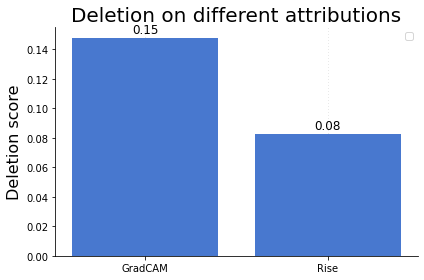

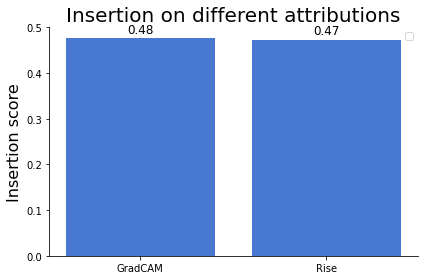

In [ ]:
# load a model
model = tf.keras.applications.InceptionV3()

methods_params = [
    ("GradCAM", GradCAM, {}),
    ("Rise", Rise, {"batch_size": 120, "nb_samples":8000})
]

deletion_scores = []
insertion_scores = []
ticklabels = []

metric_d = Deletion(model, imgs, labels)
metric_i = Insertion(model, imgs, labels)

for name, Cls, params in methods_params:

    explainer   = Cls(model, **params)
    explanations = explainer(imgs, labels)
    score_d = metric_d.evaluate(explanations)
    score_i = metric_i.evaluate(explanations)

    deletion_scores.append(score_d)
    insertion_scores.append(score_i)
    ticklabels.append(name)

plot_histogram_d(deletion_scores, ticklabels)

insertion_scores = []
for name, Cls, params in methods_params:

    explainer   = Cls(model, **params)
    explanations = explainer(imgs, labels)
    score_i = metric_i.evaluate(explanations)

    insertion_scores.append(score_i)
    ticklabels.append(name)

plot_histogram_i(insertion_scores, ticklabels)


In [ ]:
# obtaining individual metric scores for Grad-CAM
model = tf.keras.applications.InceptionV3()
# load the explainer we want to evaluate
explainer = GradCAM(model)
print("\n")
for img_name, label in img_list:
  name = np.expand_dims(tf.keras.preprocessing.image.load_img(img_name, target_size=(299, 299)), 0)
  name = np.array(name, dtype=np.float32) / 255.0
  label = np.expand_dims(tf.keras.utils.to_categorical(label, 1000), 0)
  explanations = explainer(name, label)
  # time to evaluate the quality of Rise to explain InceptionV3 prediction on our fox image
  metric = Deletion(model, name, label)
  score_d = metric.evaluate(explanations)
  metric = Insertion(model, name, label)
  score_i = metric.evaluate(explanations)
  print("For: %s GradCAM deletion score is: %0.3f and insertion score is: %0.3f"%(img_name, score_d, score_i))

/usr/local/lib/python3.7/dist-packages/xplique/attributions/base.py:139: UserWarning: Output is after softmax, it is recommended to use the layer before.
  warnings.warn("Output is after softmax, it is recommended to "




For: goldfish.jpg GradCAM deletion score is: 0.248 and insertion score is: 0.346
For: fox.jpg GradCAM deletion score is: 0.087 and insertion score is: 0.731
For: turtle.jpg GradCAM deletion score is: 0.107 and insertion score is: 0.352


In [ ]:
# creating array with important data
label_name = []
top_pred = []
deletion_score = [] 
insertion_score = []
model = tf.keras.applications.InceptionV3()
explainer = GradCAM(model)
lista = np.array(img_list)
for img_name, label in img_list:
  label_n = np.array(get_class_name(label))
  label_name.append(label_n)

  imagen = np.expand_dims(tf.keras.preprocessing.image.load_img(img_name, target_size=(299, 299)), 0)
  imagen = np.array(imagen, dtype=np.float32) / 255.0
  pred = model.predict(imagen)
  pred = np.array(pred)
  pred = np.transpose(pred)
  top = max(pred)
  top_pred.append(top)

  name = np.expand_dims(tf.keras.preprocessing.image.load_img(img_name, target_size=(299, 299)), 0)
  name = np.array(name, dtype=np.float32) / 255.0
  label = np.expand_dims(tf.keras.utils.to_categorical(label, 1000), 0)
  explanations = explainer(name, label)
  metric = Deletion(model, name, label)
  score_d = metric.evaluate(explanations)
  deletion_score.append(score_d)
  metric = Insertion(model, name, label)
  score_i = metric.evaluate(explanations)
  insertion_score.append(score_i)
lista = np.c_[lista,label_name]
lista = np.c_[lista,top_pred]
lista = np.c_[lista,deletion_score]
lista = np.c_[lista,insertion_score]
print(lista)

/usr/local/lib/python3.7/dist-packages/xplique/attributions/base.py:139: UserWarning: Output is after softmax, it is recommended to use the layer before.
  warnings.warn("Output is after softmax, it is recommended to "


[['goldfish.jpg' '1' 'goldfish' '0.99980766' '0.24807658791542053'
  '0.34607067704200745']
 ['fox.jpg' '277' 'red fox' '0.828864' '0.08674012869596481'
  '0.731336772441864']
 ['turtle.jpg' '35' 'mud turtle' '0.7691883' '0.10743121057748795'
  '0.3516514003276825']]


In [ ]:
# using pandas with the array created
df = pd.DataFrame(lista, columns=['Image_Name', 'Label_Number', 'Label_Name', 'Score', 'Deletion Score', 'Insertion Score'])
print('{}\n'.format(df))

          Image_Name Label_Number         Label_Name       Score  \
0     goldfish01.jpg            1           goldfish  0.99831736   
1        shark01.jpg            2  great white shark  0.51152563   
2          hen01.jpg            8                hen   0.6777082   
3       bulbul01.jpg           16             bulbul   0.9469976   
4      axolotl01.jpg           29            axolotl   0.9226038   
..               ...          ...                ...         ...   
95  microphone05.jpg          650         microphone  0.66982955   
96     spatula05.jpg          813            spatula  0.99057823   
97     toaster05.jpg          859            toaster   0.9972746   
98     pretzel05.jpg          932            pretzel   0.8812085   
99      banana05.jpg          954             banana  0.77465457   

         Deletion Score      Insertion Score  
0    0.1782863438129425   0.8964309692382812  
1   0.03983736410737038  0.31371456384658813  
2   0.06169784069061279    0.4145202636718

In [ ]:
# creating a file with the pandas imformation
df.to_csv('Lista.csv')

In [ ]:
# checking the file created
read = pd.read_csv('Lista.csv')
print(read)

    Unnamed: 0        Image_Name  Label_Number         Label_Name     Score  \
0            0    goldfish01.jpg             1           goldfish  0.998317   
1            1       shark01.jpg             2  great white shark  0.511526   
2            2         hen01.jpg             8                hen  0.677708   
3            3      bulbul01.jpg            16             bulbul  0.946998   
4            4     axolotl01.jpg            29            axolotl  0.922604   
..         ...               ...           ...                ...       ...   
95          95  microphone05.jpg           650         microphone  0.669830   
96          96     spatula05.jpg           813            spatula  0.990578   
97          97     toaster05.jpg           859            toaster  0.997275   
98          98     pretzel05.jpg           932            pretzel  0.881208   
99          99      banana05.jpg           954             banana  0.774655   

    Deletion Score  Insertion Score  
0         0.1

## Process of the metrics for RISE


In [ ]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

In [ ]:
explainer = RISE(model, (224, 224))
explainer.generate_masks(N=5000, s=10, p1=0.1)

Generating filters: 100%|██████████| 5000/5000 [00:25<00:00, 199.75it/s]


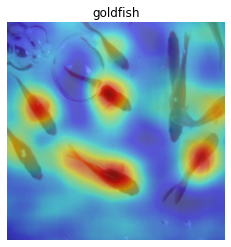

In [ ]:
# 1 is for 'goldfish' class
# 35 if for 'mud turtle' class
sal = explainer(img.cuda())[1].cpu().numpy()

tensor_imshow(img[0])
plt.axis('off')
plt.title(get_class_name(1))
plt.imshow(sal, cmap='jet', alpha=0.5)
plt.show()


## Evaluating metrics for a single image

Image on the left is the final image in the **deletion** process. It's an all-zero image for the network. It is gray instead of black, because we are setting pixels to $0$ in the space of normalized images. So after denormalization it becomes equal to the ImageNet mean which is $[0.485, 0.456, 0.406]$.

In [ ]:
h = deletion.single_run(img, sal, verbose=1)

In [ ]:
h = insertion.single_run(img, sal, verbose=1)